In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xlrd

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import scipy.stats as st

In [2]:
data = pd.read_excel('Diet.xlsx', engine='openpyxl')

In [3]:
data.isnull().any().any()

False

In [4]:
data.head()

,gender,Diet,weight,weight6weeks
0,M,B,60,60.0
1,M,B,103,103.0
2,F,A,58,54.2
3,F,A,60,54.0
4,F,A,64,63.3


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        78 non-null     object 
 1   Diet          78 non-null     object 
 2   weight        78 non-null     int64  
 3   weight6weeks  78 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.6+ KB


In [6]:
data['gender'].value_counts()

F    43
M    35
Name: gender, dtype: int64

In [7]:
data['Diet'].value_counts()

C    27
B    27
A    24
Name: Diet, dtype: int64

In [8]:
data = data.assign(delta = data['weight'] - data['weight6weeks'])

In [9]:
data.head()

,gender,Diet,weight,weight6weeks,delta
0,M,B,60,60.0,0.0
1,M,B,103,103.0,0.0
2,F,A,58,54.2,3.8
3,F,A,60,54.0,6.0
4,F,A,64,63.3,0.7


### 1. Проверка предпосылок, лежащих в основе дисперсионного анализа

*если значения зависимой переменной в каждой экспериментальной группе распределены нормально, то нормально будут распределены и значения остатков соответствующей линейной модели.*

In [10]:
st.shapiro(data['delta'])

ShapiroResult(statistic=0.9899073839187622, pvalue=0.8019384145736694)

Данные имеют нормальное распределение

Проверим гипотезы об однородности распределений

In [11]:
st.bartlett(data['delta'][data['gender']=='M'], data['delta'][data['gender']=='F'])

BartlettResult(statistic=0.073364459569544, pvalue=0.7864996762413055)

In [12]:
st.bartlett(data['delta'][data['Diet']=='A'], data['delta'][data['Diet']=='B'], data['delta'][data['Diet']=='C'])

BartlettResult(statistic=0.337454630479139, pvalue=0.8447392194944549)

Дисперсии однородны, нулевая гипотеза принимается в обоих случаях

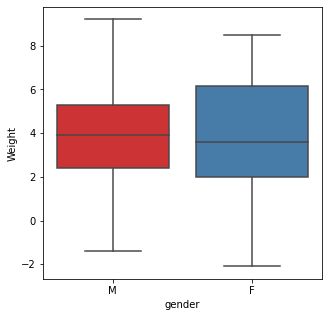

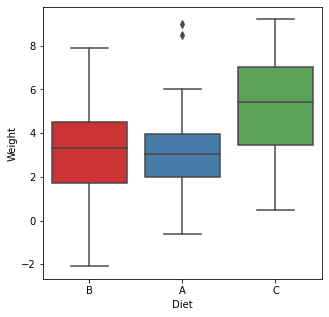

In [13]:
temp_data = pd.melt(data,
                    id_vars=['gender', 'Diet'],
                    value_vars=['delta'],
                    value_name='Weight')

plt.figure(figsize=(5,5))
ax = sns.boxplot(x="gender", y="Weight", data=temp_data, palette="Set1")
plt.show()

plt.figure(figsize=(5,5))
ax = sns.boxplot(x="Diet", y="Weight", data=temp_data, palette="Set1")
plt.show()

### 2. Средние значения и стандартные отклонения

In [14]:
print(f"Среднее значение в группе Male - {np.mean(data['delta'][data['gender']=='M'])}")
print(f"Среднее значение в группе Female - {np.mean(data['delta'][data['gender']=='F'])}\n")

print(f"Стандартное отклонение в группе Male - {np.std(data['delta'][data['gender']=='M'])}")
print(f"Стандартное отклонение в группе Female - {np.std(data['delta'][data['gender']=='F'])}\n")

print(f"Среднее значение в группе с диетой A - {np.mean(data['delta'][data['Diet']=='A'])}")
print(f"Среднее значение в группе с диетой B - {np.mean(data['delta'][data['Diet']=='B'])}")
print(f"Среднее значение в группе с диетой C - {np.mean(data['delta'][data['Diet']=='C'])}\n")

print(f"Стандартное отклонение в группе с диетой A - {np.std(data['delta'][data['Diet']=='A'])}")
print(f"Стандартное отклонение в группе с диетой B - {np.std(data['delta'][data['Diet']=='B'])}")
print(f"Стандартное отклонение в группе с диетой C - {np.std(data['delta'][data['Diet']=='C'])}\n")

Среднее значение в группе Male - 3.7857142857142856
Среднее значение в группе Female - 3.893023255813953

Стандартное отклонение в группе Male - 2.5923120245551186
Стандартное отклонение в группе Female - 2.4864652550509208

Среднее значение в группе с диетой A - 3.2999999999999994
Среднее значение в группе с диетой B - 3.025925925925926
Среднее значение в группе с диетой C - 5.148148148148147

Стандартное отклонение в группе с диетой A - 2.1929812280698306
Стандартное отклонение в группе с диетой B - 2.476196694244443
Стандартное отклонение в группе с диетой C - 2.350787160580136



### 3. Тест на межгрупповые различия с учетом межфакторного воздействия и без

#### 3.1 Однофакторный дисперсионный анализ

Проверка влияния фактора 𝐴 на изменение математических ожиданий. Здача может быть сведена к сравнению дисперсий 𝜎̂𝐴^2 и 𝜎̂0^2. 

In [15]:
def assessing_var(data):  # Оценка дисперсии
    var = 0
    mean = np.mean(data)
    for i in range(len(data)):
        var += (float(list(data)[i]) - mean)**2
    var *= float(1)/(len(data)-1)
    return var

In [16]:
print(assessing_var(data['delta'].loc[data['gender']=='M']) / assessing_var(data['delta']))

1.0626252533275282


In [17]:
print(assessing_var(data['delta'].loc[data['gender']=='F']) / assessing_var(data['delta']))

0.9723002821195583


Иначе можно просто проверить гипотезу о равенстве средних $H_0: m_1=m_2=...=m_k$

In [18]:
_, p = st.f_oneway(data['delta'].loc[data['gender']=='F'], data['delta'].loc[data['gender']=='M'])
print(f'p-value: {p:.4f}')

alpha = 0.05

if p >= alpha:
    print(f'Нулевая гипотеза принимается')
else:
    print(f'Нулевая гипотеза отвергается')

p-value: 0.8548
Нулевая гипотеза принимается


Как можно видеть, фактор гендера не особо влияет на изменение в весе. То есть можно сказать, что пол человека никак не будет влиять на похудение, <b>исходя из однофакторного анализа</b>

In [19]:
print(assessing_var(data['delta'].loc[data['Diet']=='A']) / assessing_var(data['delta']))

0.7708496697154525


In [20]:
print(assessing_var(data['delta'].loc[data['Diet']=='B']) / assessing_var(data['delta']))

0.9780862460105499


In [21]:
print(assessing_var(data['delta'].loc[data['Diet']=='C']) / assessing_var(data['delta']))

0.8815226852229571


In [22]:
_, p = st.f_oneway(data['delta'].loc[data['Diet']=='A'], 
                   data['delta'].loc[data['Diet']=='B'],
                   data['delta'].loc[data['Diet']=='C'])
print(f'p-value: {p:.4f}')

alpha = 0.05

if p >= alpha:
    print(f'Нулевая гипотеза принимается')
else:
    print(f'Нулевая гипотеза отвергается')

p-value: 0.0032
Нулевая гипотеза отвергается


Здесь же в данном случае выбор диеты влиял на похудение. Влияние фактора выбора диеты является значительным

Выясним как группы различаются между собой

Воспользуемся критерием Тьюки

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B  -0.2741    0.9 -1.8806 1.3325  False
     A      C   1.8481 0.0201  0.2416 3.4547   True
     B      C   2.1222 0.0048  0.5636 3.6808   True
---------------------------------------------------


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


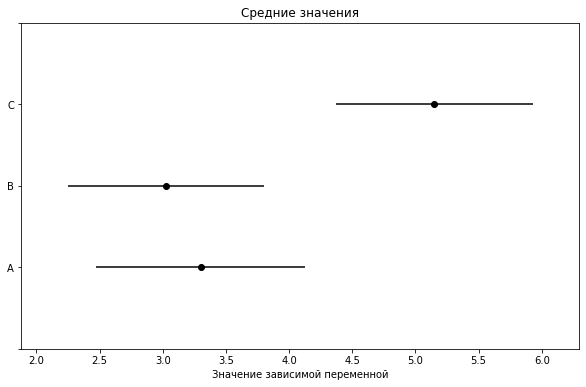

In [23]:
# Создадим экземпляр класса MultiComparison и передадим параметры из data
MultiComp = MultiComparison(data['delta'], data['Diet'])
# вычислим значение критерия Тьюки с уровнем значимости 0.05
alpha = 0.05
results = MultiComp.tukeyhsd(alpha)

# результат
print(results.summary())
# визуализируем
fig = results.plot_simultaneous(xlabel='Значение зависимой переменной')
fig.get_axes()[0].title.set_text('Средние значения')

Теперь мы можем сделать вывод, что по сути диета A и B не имеют разного влияния на сброс веса. Об этом можно было догадываться из прошлых итераций, но теперь точно стало видно - ответ False (гипотеза о равенстве средних подтвердилась). Но между тем диета 'C' имеет влияние, различное от двух предыдущих.

#### 3.2 Двухфакторный дисперсионный анализ

In [24]:
temp_data = pd.melt(data,
                    id_vars=['gender', 'Diet'],
                    value_vars=['delta'],
                    value_name='Delta')
del temp_data['variable']
temp_data


,gender,Diet,Delta
0,M,B,0.0
1,M,B,0.0
2,F,A,3.8
3,F,A,6.0
4,F,A,0.7
...,...,...,...
73,M,C,2.8
74,M,C,4.1
75,M,C,5.3
76,M,C,9.2


In [25]:
from bioinfokit.analys import stat
res = stat()

In [26]:
res.tukey_hsd(df=temp_data, 
              res_var='Delta', 
              xfac_var=['gender','Diet'], 
              anova_model='Delta ~ C(gender) + C(Diet) + C(gender):C(Diet)')
result = res.tukey_summary
print(result)

    group1  group2      Diff     Lower     Upper   q-value   p-value
0   (M, B)  (M, A)  0.173077 -2.747292  3.093446  0.245388  0.900000
1   (M, B)  (M, C)  0.756410 -2.023004  3.535824  1.126822  0.900000
2   (M, B)  (F, B)  0.869780 -1.804407  3.543967  1.346694  0.900000
3   (M, B)  (F, A)  0.426923 -2.247264  3.101110  0.661012  0.900000
4   (M, B)  (F, C)  2.403077 -0.227841  5.033995  3.781914  0.093072
5   (M, A)  (M, C)  0.583333 -2.389471  3.556137  0.812460  0.900000
6   (M, A)  (F, B)  1.042857 -1.831807  3.917522  1.502066  0.892905
7   (M, A)  (F, A)  0.600000 -2.274664  3.474664  0.864202  0.900000
8   (M, A)  (F, C)  2.230000 -0.604457  5.064457  3.257513  0.206189
9   (M, C)  (F, B)  1.626190 -1.105161  4.357542  2.465160  0.506967
10  (M, C)  (F, A)  1.183333 -1.548018  3.914685  1.793828  0.775988
11  (M, C)  (F, C)  1.646667 -1.042336  4.335669  2.535513  0.477610
12  (F, B)  (F, A)  0.442857 -2.181340  3.067055  0.698745  0.900000
13  (F, B)  (F, C)  3.272857  0.69

In [27]:
import plotly
import plotly.graph_objs as go

In [28]:
fig1 = go.Scatter3d(x=data['gender'],
                    y=data['Diet'],
                    z=data['delta'],
                    marker=dict(opacity=0.9,
                                reversescale=True,
                                colorscale='Blues',
                                size=5),
                    line=dict (width=0.02),
                    mode='markers')

#Make Plot.ly Layout
mylayout = go.Layout(scene=dict(xaxis=dict( title="Gender"),
                                yaxis=dict( title="Type of Diet"),
                                zaxis=dict(title="Delta of weight")),)

#Plot and save html
plotly.offline.plot({"data": [fig1],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("3DPlot.html"))

'3DPlot.html'

Теперь уже можно сделать вывод, что и пол влияет на общий показатель. Для женщин следует применять диету 'C'. Остальные параметры прошли пороговое значение. Из графика тожно можно сделать вывод, что величины диет {A,B} и {C} распределены не одинаково. В мужском же случае это особо не влияет, есть выбросы из статистики, но это всего лишь 2 мужчин, кому диета 'C' дала результаты больше, чем средние показатели в диете 'A' и 'B'. Стоит также обратить внимание, что и с диетой 'A' и 'B' у мужчин есть аномальные значения

Это говорит о том, что исходя из однофакторного анализа мы сделали ошибочный вывод. На самом деле пол влияет на результат.

Чтобы подтвердить нашу гипотезу проведем однофакторный анализ для зависимой переменной, но где будут данные только по мужскому полу

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B  -0.1731    0.9 -2.9519 2.6058  False
     A      C   0.5833 0.8593 -2.2454 3.4121  False
     B      C   0.7564 0.7475 -1.8883 3.4011  False
---------------------------------------------------


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



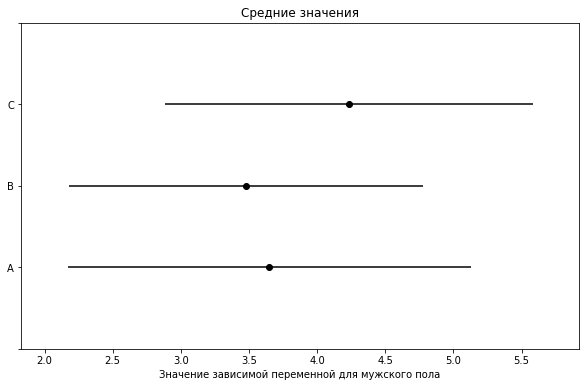

In [29]:
# Создадим экземпляр класса MultiComparison и передадим параметры из data
MultiComp = MultiComparison(data['delta'][data['gender']=='M'], data['Diet'][data['gender']=='M'])
# вычислим значение критерия Тьюки с уровнем значимости 0.05
alpha = 0.05
results = MultiComp.tukeyhsd(alpha)

# результат
print(results.summary())
# визуализируем
fig = results.plot_simultaneous(xlabel='Значение зависимой переменной для мужского пола')
fig.get_axes()[0].title.set_text('Средние значения')

Оказывается, действительно, выбор диеты для мужчин не имеет серьёзного влияния, тест провалился, везде значение False.